In [ ]:
import cv2
import os
import numpy as np

In [ ]:
inference_type="coarse"

In [ ]:
try:
  from sentence_transformers import SentenceTransformer
except:
  !pip install sentence_transformers
  from sentence_transformers import SentenceTransformer
if inference_type=="coarse":
  model = SentenceTransformer('all-mpnet-base-v2')
else:
  model= SentenceTransformer('multi-qa-mpnet-base-cos-v1')

In [ ]:
with open('test.label', encoding = "ISO-8859-1") as f:
  test = f.readlines()
    
with open('train.label', encoding = "ISO-8859-1") as f:
  train = f.readlines()
    

In [ ]:
test_sentences=[]
test_fine_label=[]
test_coarse_label=[]
test_first_bigram=[]
for sentence in test:
  test_sentences.append(sentence[:-1].split(' ', 1)[1])
  test_fine_label.append(sentence[:-1].split(' ', 1)[0])
  test_coarse_label.append(test_fine_label[-1].split(':',1)[0])
  test_first_bigram.append(' '.join([b for l in [test_sentences[-1]] for b in zip(l.split(" ")[:-1], l.split(" ")[1:])][0]))
train_sentences=[]
train_fine_label=[]
train_coarse_label=[]
train_first_bigram=[]
for sentence in train:
  train_sentences.append(sentence[:-1].split(' ', 1)[1])
  train_fine_label.append(sentence[:-1].split(' ', 1)[0])
  train_coarse_label.append(train_fine_label[-1].split(':',1)[0])
  train_first_bigram.append(' '.join([b for l in [train_sentences[-1]] for b in zip(l.split(" ")[:-1], l.split(" ")[1:])][0]))

In [ ]:
if inference_type=="coarse":
  test_encodings = model.encode(test_sentences)
  train_encodings = model.encode(train_sentences)
else:
  test_encodings = np.concatenate((model.encode(test_first_bigram), model.encode(test_sentences)), axis=1)
  train_encodings = np.concatenate((model.encode(train_first_bigram), model.encode(train_sentences)), axis=1)

# test_encodings = model.encode(test_first_bigram)
# train_encodings = model.encode(train_first_bigram)



In [ ]:
unique_coarse_label=list(set(train_coarse_label))
unique_fine_label=list(set(train_fine_label))

In [ ]:
len(unique_fine_label)

50

In [ ]:
train_c=np.array([unique_coarse_label.index(coarse_label) for coarse_label in train_coarse_label])
train_f=np.array([unique_fine_label.index(fine_label) for fine_label in train_fine_label])
test_c=np.array([unique_coarse_label.index(coarse_label) for coarse_label in test_coarse_label])
test_f=np.array([unique_fine_label.index(fine_label) for fine_label in test_fine_label])


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
import pickle
import math
import torch
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Bidirectional


In [ ]:
sentence_representation = Input(shape=(train_encodings.shape[1],))
merged=Dense(train_encodings.shape[1], activation='relu')(sentence_representation)
merged=Dense(1400, activation='relu')(merged)
merged=Dense(1000, activation='relu')(merged)
merged=Dense(900, activation='relu')(merged)
merged=Dense(700, activation='relu')(merged)
merged=Dense(500, activation='relu')(merged)
merged=Dense(200, activation='relu')(merged)
merged=Dense(50, activation='relu')(merged)
# merged=Dense(20, activation='relu')(merged)
if inference_type=="coarse":
  merged=Dense(len(set(train_coarse_label)), activation='softmax')(merged)
else:
  merged=Dense(len(set(train_fine_label)), activation='softmax')(merged)

In [ ]:
enc_dec_model = Model(sentence_representation, Activation('softmax')(merged))
enc_dec_model.compile(loss=sparse_categorical_crossentropy,
            optimizer=Adam(1e-3),
            metrics=['accuracy'])
enc_dec_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1536)]            0         
                                                                 
 dense_36 (Dense)            (None, 1536)              2360832   
                                                                 
 dense_37 (Dense)            (None, 1400)              2151800   
                                                                 
 dense_38 (Dense)            (None, 1000)              1401000   
                                                                 
 dense_39 (Dense)            (None, 900)               900900    
                                                                 
 dense_40 (Dense)            (None, 700)               630700    
                                                                 
 dense_41 (Dense)            (None, 500)               3505

In [ ]:
from tensorflow.keras import backend as K
K.set_value(enc_dec_model.optimizer.learning_rate, 1e-5)

In [ ]:
if inference_type=="coarse":
  history = enc_dec_model.fit(train_encodings,train_c, batch_size=300, epochs=197,validation_split = 0.1)
else:
  history = enc_dec_model.fit(train_encodings,train_f, batch_size=300, epochs=197,validation_split = 0.1)

Epoch 1/97
17/17 [==============================] - 0s 14ms/step - loss: 3.5002 - accuracy: 0.4450 - val_loss: 3.5213 - val_accuracy: 0.4267
Epoch 2/97
17/17 [==============================] - 0s 11ms/step - loss: 3.5000 - accuracy: 0.4454 - val_loss: 3.5207 - val_accuracy: 0.4249
Epoch 3/97
17/17 [==============================] - 0s 9ms/step - loss: 3.4997 - accuracy: 0.4456 - val_loss: 3.5205 - val_accuracy: 0.4286
Epoch 4/97
17/17 [==============================] - 0s 9ms/step - loss: 3.4994 - accuracy: 0.4456 - val_loss: 3.5202 - val_accuracy: 0.4267
Epoch 5/97
17/17 [==============================] - 0s 8ms/step - loss: 3.4993 - accuracy: 0.4456 - val_loss: 3.5205 - val_accuracy: 0.4267
Epoch 6/97
17/17 [==============================] - 0s 9ms/step - loss: 3.4991 - accuracy: 0.4456 - val_loss: 3.5198 - val_accuracy: 0.4286
Epoch 7/97
17/17 [==============================] - 0s 9ms/step - loss: 3.4991 - accuracy: 0.4456 - val_loss: 3.5197 - val_accuracy: 0.4286
Epoch 8/97
17/17 [

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


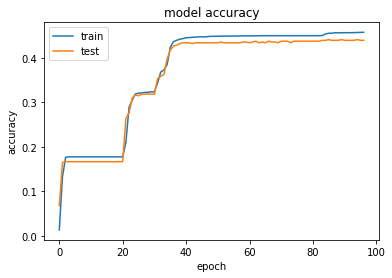

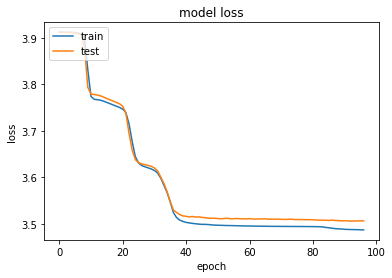

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
enc_dec_model.save('/content/drive1/MyDrive/cs728a3/ati_c_92.h5')


In [ ]:
enc_dec_model=tf.keras.models.load_model('/content/drive1/MyDrive/cs728a3/ati_f_52.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive1')

Mounted at /content/drive1


In [ ]:
score, acc = enc_dec_model.evaluate(test_encodings, test_f)
print('Test loss:', score)
print('Test accuracy:', acc)

16/16 [==============================] - 0s 3ms/step - loss: 3.4237 - accuracy: 0.5220
Test loss: 3.423675537109375
Test accuracy: 0.5220000147819519


# Testing

In [ ]:
test_prediction=enc_dec_model.predict(test_encodings)

In [ ]:
y_hat=[unique_coarse_label[id] for id in np.argmax(test_prediction,axis=1)]

In [ ]:
x=test_sentences

In [ ]:
import pandas as pd  
  

# dictionary of lists  
dict = {'Question': x,"Answer Type Coarse Grained":y_hat}  
       
df_out = pd.DataFrame(dict) 
    
# saving the dataframe 
df_out.to_csv('coarse_grained_ATI.csv') 